# Performance Measures

The following discusses using cross-validation to evaluate the classifier we built in the [previous post](https://scottminer.netlify.app/post/binary-classifier/), which classifies images from the MNIST dataset as either five or not five.

## Measuring Accuracy Using Cross-Validation

---

Let's take a brief look at the problem that cross-validation solves.

When building a model, we risk **overfitting** the model on the test set when evaluating different hyperparameters. This is because we can tweak the hyperparameters until the model performs optimally. In overfitting, knowledge about the test set "leaks" into the model, and evaluation metrics no longer report on generalization.

One solution is to divide the data into another hold-out set, called the "validation set," which provides evaluation after the model completes training. We can then perform a final model assessment using our test set once the model appears successful.

A disadvantage of this approach is that it reduces the number of samples available to train the model since it partitions the data into three sets: training, validation, and test sets. Also, our results may depend on a particular random pairing of the training and validation sets.

The solution is to use cross-validation. When performing cross-validation, the validation set is no longer needed. We still need the test set for final evaluation. The most basic version of this approach is known as *k*-fold CV, which splits the training data into _k_ smaller groups. The approach trains and evaluates the model *k* times, picking a different fold for evaluation every time and training on the remaining folds. The following describes this process:

* Train a model using $k - 1$ of the folds as training data
* Use the remaining part of the data to validate the model
* Compute a performance measure such as accuracy

The performance measure reported by *k*-fold CV is the average of the values computed in the loop. *k*-fold CV is computationally expensive but offers a significant advantage in problems like inverse inference when sample sizes are small. Also, the process does not waste as much data as fixing an arbitrary validation set. Last but not least, *k*-fold CV allows us to get not only an estimate of the model's performance but also a measure of how precise that estimate is (i.e., standard deviation). We would not have this information with only one validation set. Figure 1 depicts *k*-fold CV.

![](./images-md/grid_search_cross_validation.png)
<center>[Fig. 1 Cross Validation](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation)</center>

Let's look at a simple example of *k*-fold CV using `cross_val_score()` from `sklearn`.

In [63]:
from sklearn.model_selection import cross_val_score
from sklearn import datasets, linear_model
diabetes = datasets.load_diabetes()
X = diabetes.data[:150]
y = diabetes.target[:150]
lasso = linear_model.Lasso()
scores = cross_val_score(lasso, X, y, cv=3)

Below are all the functions available on the `scores` object, including the `mean` and `std`.

In [64]:
print(*[x for x in dir(scores) if not x.startswith('_')])

T all any argmax argmin argpartition argsort astype base byteswap choose clip compress conj conjugate copy ctypes cumprod cumsum data diagonal dot dtype dump dumps fill flags flat flatten getfield imag item itemset itemsize max mean min nbytes ndim newbyteorder nonzero partition prod ptp put ravel real repeat reshape resize round searchsorted setfield setflags shape size sort squeeze std strides sum swapaxes take tobytes tofile tolist tostring trace transpose var view


In [65]:
print(f'Scores: {scores}')
print(f'Mean: {scores.mean()}')
print(f'Standard Deviation: {scores.std()}')

Scores: [0.33150734 0.08022311 0.03531764]
Mean: 0.14901602799979094
Standard Deviation: 0.1303365724319238


(The model does not perform that well.)

Sometimes we may need more control over the CV process than a function like `cross_val_score()` provides. In these cases, we can implement a version of the cross-validation process from scratch. To do so, we use `StratifiedKFold`. Let's take a closer look at it.

### Stratified k-fold

---

`StratifiedKFold` is a variation of *k*-fold CV that returns *stratified* folds. In stratified folds, each fold contains approximately the same percentage of samples for each class. Let's take a look at a simple example. `StratifiedKFold` provides train/test indices to split data into train/test sets.

In [66]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([0, 0, 1, 1])
original_data = pd.DataFrame(np.c_[X, y], columns=['Feature1', 'Feature2',
                                                   'Target'], index=['index_0', 'index_1', 'index_2', 'index_3'])

display(original_data)
skf = StratifiedKFold(n_splits=2)
print(f'Number of splits: {skf.get_n_splits(X, y)}')
print(skf)

,Feature1,Feature2,Target
index_0,1,2,0
index_1,3,4,0
index_2,1,2,1
index_3,3,4,1


Number of splits: 2
StratifiedKFold(n_splits=2, random_state=None, shuffle=False)


The `split()` method of a cross-validation object yields two $n$-dimensional arrays containing the training and testing set indices for each partition.


In [67]:
import pandas as pd
print('Original Dataset')
display(original_data)
for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
    print('---')
    print()
    print(f'Fold #{fold}:')
    print(f'TRAIN_INDEX: {train_index} TEST_INDEX: {test_index}')
    print()
    X_train_ex, X_test_ex = X[train_index], X[test_index]
    y_train_ex, y_test_ex = y[train_index], y[test_index]
    print('---')
    print()
    print('Training Set')
    display(pd.DataFrame(np.c_[X_train_ex, y_train_ex.T],
                         columns=['Feature1', 'Feature2', 'Target'],
                         index=['Sample1', 'Sample2']))
    print('Testing Set')
    display(pd.DataFrame(np.c_[X_test_ex, y_test_ex.T],
                         columns=['Feature1', 'Feature2', 'Target'],
                         index=['Sample1', 'Sample2']))

Original Dataset


,Feature1,Feature2,Target
index_0,1,2,0
index_1,3,4,0
index_2,1,2,1
index_3,3,4,1


---

Fold #1:
TRAIN_INDEX: [1 3] TEST_INDEX: [0 2]

---

Training Set


,Feature1,Feature2,Target
Sample1,3,4,0
Sample2,3,4,1


Testing Set


,Feature1,Feature2,Target
Sample1,1,2,0
Sample2,1,2,1


---

Fold #2:
TRAIN_INDEX: [0 2] TEST_INDEX: [1 3]

---

Training Set


,Feature1,Feature2,Target
Sample1,1,2,0
Sample2,1,2,1


Testing Set


,Feature1,Feature2,Target
Sample1,3,4,0
Sample2,3,4,1


In the above example, indices `[1, 3]` serve as the premise for the `training set` in the first fold, and indices `[0, 2]` serve as the basis for the validation set. The second fold reverses these indices. In other words, each fold serves as the validation set exactly once.

#### np.bincount()

---

We can use `np.bincount()` to compare stratified and non-stratified *k*-fold cross-validation.

First, let's take a closer look at `np.bincount()`. The function `np.bincount()` counts the number of occurrences of each value in an array of non-negative integers.

In [68]:
print(np.arange(5))
print(np.bincount(np.arange(5)))

[0 1 2 3 4]
[1 1 1 1 1]


Each value in the initial array occurs once, which the output from `np.bincount()` demonstrates. The numbers in the array correspond to the counts of the original value. The indices represent the values of the original array. Let's look at another example.

In [69]:
print(np.array([0, 1, 1, 3, 2, 1, 7]))
print(np.bincount(np.array([0, 1, 1, 3, 2, 1, 7])))

[0 1 1 3 2 1 7]
[1 3 1 1 0 0 0 1]


In [70]:
print(np.array([0, 1, 1, 3, 2, 1, 7]))
print(np.bincount(np.array([0, 1, 1, 3, 2, 1, 7])))

[0 1 1 3 2 1 7]
[1 3 1 1 0 0 0 1]


The number of bins (of size 1) is one larger than the largest value in the array.


In [71]:
x = np.array([0, 1, 1, 3, 2, 1, 7, 23])
np.bincount(x).size == np.amax(x) + 1

True

#### Random 50 samples

---

Let's use `np.bincount()` to compare stratified and non-stratified *k*-fold CV using 50 samples from two unbalanced classes.


In [72]:
from sklearn.model_selection import StratifiedKFold, KFold
import numpy as np

X, y = np.ones((50, 1)), np.hstack(([0] * 45, [1] * 5))
print(f'X.shape: {X.shape}')
print(f'First five rows of Features: \n{X[:5]}')
print(f'y.shape: {y.shape}')
print('First and last five indices of target variable')
print(np.concatenate((y[:5], y[-5:]), axis=None))

X.shape: (50, 1)
First five rows of Features: 
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]]
y.shape: (50,)
First and last five indices of target variable
[0 0 0 0 0 1 1 1 1 1]


Notice the difference in the shapes of the `X` and `y` $n$-dimensional arrays. The shape of `X` is `(50, 1)`, which correlates to 50 rows and 1 column. The shape of `y`, on the other hand, is `(50,)`. In the latter case, the array is 1-dimensional and is otherwise known as a vector. In the former case, the array is a 2-dimensional array.

In [73]:
skf = StratifiedKFold(n_splits=3)
for train, test in skf.split(X, y):
    print(f'train - {np.bincount(y[train])} | test - {np.bincount(y[test])}')


train - [30  3] | test - [15  2]
train - [30  3] | test - [15  2]
train - [30  4] | test - [15  1]


In [74]:
kf = KFold(n_splits=3)
for train, test in kf.split(X, y):
    print(f'train - {np.bincount(y[train])} | test - {np.bincount(y[test])}')


train - [28  5] | test - [17]
train - [28  5] | test - [17]
train - [34] | test - [11  5]


The first method, `StratifiedKFold`, preserves the class ratios (approximately $\frac{1}{10}$) in both the training and testing sets compared to the basic implementation, which does not.

#### Visualizing Cross-Validation Behaviour

---

We can visualize the behavior of *k*-fold, stratified *k*-fold, and group *k*-fold CV. The code below creates a dataset with 100 randomly generated input data points, three classes split unevenly across data points, and 10 "groups" split evenly across data points. Some CV approaches do specific things with labeled data, others behave differently with grouped data, and others do not use this information. Let's take a look at the structure of the data.



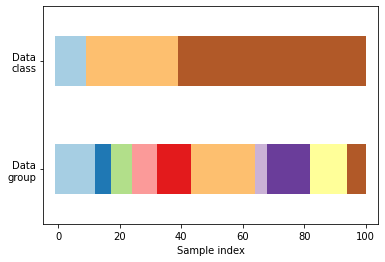

In [75]:
"""
Visualizing cross-validation behavior in scikit-learn
=====================================================

Choosing the right cross-validation object is a crucial part of fitting a
model properly. There are many ways to split data into training and test
sets in order to avoid model overfitting, to standardize the number of
groups in test sets, etc.

This example visualizes the behavior of several common scikit-learn objects
for comparison.

"""

import numpy.random as rng
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    GroupKFold
)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

rng = np.random.RandomState(1338)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
n_splits = 4
# Generate the class/group data
n_points = 100
X = rng.randn(100, 10)

percentiles_classes = [0.1, 0.3, 0.6]
y = np.hstack([[ii] * int(100 * perc)
               for ii, perc in enumerate(percentiles_classes)])

# Generate uneven groups
group_prior = rng.dirichlet([2] * 10)
groups = np.repeat(np.arange(10), rng.multinomial(100, group_prior))


def visualize_groups(classes, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots()
    ax.scatter(
        range(len(groups)),
        [0.5] * len(groups),
        c=groups,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.scatter(
        range(len(groups)),
        [3.5] * len(groups),
        c=classes,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )


visualize_groups(y, groups, "no groups")


##### Define a function to visualize cross-validation behavior

---

Let's define a function that visualizes the behavior of each cross-validation object. We perform four splits of the data. We'll visualize the indices chosen for the training set (in blue) and the test set (in red) on each fold.

In [76]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax


Let's take a look at the `KFold` cross-validation object:

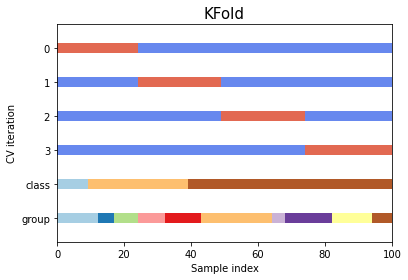

In [77]:
fig, ax = plt.subplots()
cv = KFold(n_splits)
plot_cv_indices(cv, X, y, groups, ax, n_splits)
plt.show()

As you can see, the _k_-fold CV iterator does not consider the datapoint class or group by default. We can change this by using `StratifiedKFold` or `GroupKFold` (or potentially other options).

* `StratifiedKFold` preserves the percentage of samples for each category.
* `GroupKFold` ensures that the same group will not appear in two different folds.

Let's plot all three together.

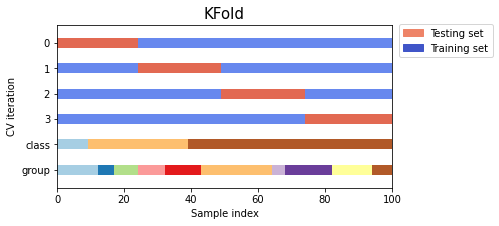

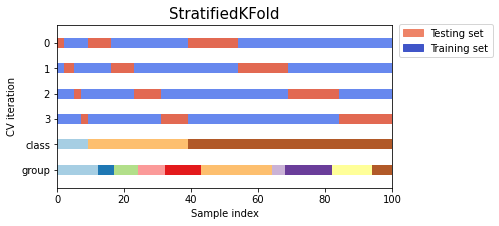

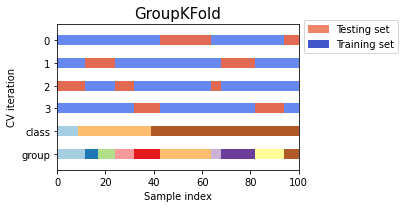

In [78]:
cvs = [KFold, StratifiedKFold, GroupKFold]

for cv in cvs:
    fig, ax = plt.subplots(figsize=(6, 3))
    plot_cv_indices(cv(n_splits), X, y, groups, ax, n_splits)
    ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
    )
# Make the legend fit
plt.tight_layout()
fig.subplots_adjust(right=0.7)


# SGDClassifier

---

The following uses stratified 3-fold cross-validation to evaluate the `SGDClassifer` we trained on the MNIST dataset. The code then counts the number of correct predictions and outputs the ratio of accurate predictions.

In [83]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

%store -r X_train
%store -r X_test
%store -r y_train
%store -r y_test
%store -r y_train_5
%store -r y_test_5
%store -r sgd_clf

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))


0.9681
0.95655
0.95515


We can also use the `cross_val_score()` function to evaluate the `SGDClassifier` model using *k*-fold CV, and we get the same results.

In [80]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9681 , 0.95655, 0.95515])

The accuracy is above 95% on all cross-validation folds. However, let's look at a dumb classifier that classifies every image as belonging to the "not-5" class. The following classifier, termed `Never5Classifier`, outputs a false prediction for each record passed to it.

In [81]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass

    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

Let's check this model's accuracy.

In [82]:
never_5_clf = Never5Classifier()
scores = cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")
print(f'Scores: {scores}')
print(f'Mean: {scores.mean():.4f}')
print(f'Standard Deviation: {scores.std():.4f}')

Scores: [0.909   0.90745 0.9125 ]
Mean: 0.9097
Standard Deviation: 0.0021


The model that never predicts a 5 has over 90% accuracy since only about 10% of the images are 5. Suppose the classifier always guesses _not_ a 5. In that case, it will be right about 90% of the time, which is why accuracy is not generally the preferred performance measure for classifiers, especially when the dataset is unbalanced. On the other hand, confusion matrices are much better suited to evaluate classifiers, which we will look at in the next post.